In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import imgaug.augmenters as ia
from imgaug import parameters as iap
from imgaug.augmentables import Keypoint, KeypointsOnImage


import random
import PIL
import os
import time
import copy
import itertools
from IPython.core.debugger import set_trace

import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import faiss


import kornia
from kornia.constants import SamplePadding
from kornia.utils import image_to_tensor, tensor_to_image

from functools import partial

import model
from model import inconv, down, up, outconv, DACblock, SPPblock
from torchvision.transforms import ToPILImage
from sklearn import metrics

%config InlineBackend.figure_format = 'retina'
device = 'cuda'
os.environ['CUDA_VISIBLE_DEVICES'] = '1, 2, 3, 4, 5'

import cv2
IMG_SIZE = 350
SEED = 101
from tqdm import tqdm
data_loc_lamina = '/data/Atin/vscodeserver_projects/SimCLR-pixel/data/'

In [2]:
class in_conv(nn.Module):
    def __init__(self, in_ch, out_ch, k_size=3, s=1):
        super(in_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=k_size),
#             nn.MaxPool2d(k_size, stride=2),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch, k_size=3, s=1):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=k_size),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(out_ch, out_ch, kernel_size=k_size),
            nn.MaxPool2d(k_size, stride=2),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            
        )

    def forward(self, x):
        x = self.conv(x)
        return x
    
class four_conv(nn.Module):
    def __init__(self, in_ch, out_ch, k_size=3, s=1):
        super(four_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=k_size),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(out_ch, out_ch, kernel_size=k_size),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(out_ch, out_ch, kernel_size=k_size),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(out_ch, out_ch, kernel_size=k_size),
            nn.MaxPool2d(k_size, stride=2),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            
            
        )

    def forward(self, x):
        x = self.conv(x)
        return x

        

class basic_cnn(nn.Module):
    '''
        Features are extracted at the last layer of decoder. 
    '''
    def __init__(self, n_channels, n_classes):
        super(basic_cnn, self).__init__()
        self.inc = in_conv(n_channels, 32)
        self.double_conv1 = double_conv(32, 32, 3)
        self.double_conv2 = double_conv(32, 64, 3)
        self.four_conv1 = four_conv(64, 128, 3)
        self.four_conv2 = four_conv(128, 256, 3)
        self.conv_drop = nn.Dropout(p=.5)
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 2)
        
        
    def forward(self, x):
        x = self.inc(x)
        x = self.double_conv1(x)
        x = self.double_conv2(x)
        x = self.four_conv1(x)
        x = self.four_conv2(x)
        x = self.conv_drop(x)
        x = F.elu(F.adaptive_avg_pool2d(x, output_size=1))
        x = x.view(-1, 256)
        x = F.elu(self.fc1(x))
        x = self.fc2(x)
        
        
        return x
        

class FundusDSwithLabel(Dataset):
    
    def __init__(self, patient_id_df, resize=(350, 350), transform=None):
        
        self.patient_id_df = patient_id_df
        self.transform = transform
        self.to_tensor = torchvision.transforms.ToTensor()
        self.resize = resize
       
        
    def __getitem__(self, index):
        
        df = self.patient_id_df.iloc[index]
        
        im_loc = df.image + '.jpeg'
        im_loc = data_loc_lamina + 'Cropped_DR/train/' + im_loc
        im = PIL.Image.open(im_loc).resize((self.resize[1],self.resize[0]))
        im = np.array(im)
        
        label = df.level
        
        
        if self.transform is not None:
            im_aug = self.transform(image=im)
            return self.to_tensor(im), self.to_tensor(im_aug), label
        else:
            return self.to_tensor(im), label
            
        
        if self.to_tensor_flag:
            return self.to_tensor(im), self.to_tensor(im_aug), label
        else:
            return im, label
    
    def __len__(self):
        return len(self.patient_id_df)

In [3]:
def auc_cal(model, testloader):
    model.eval()
    test_loss = 0
    correct = 0

    for _, (data, target) in enumerate(testloader):
        
        data, target = data.to(device), target.to(device)
        output = model(data)

        test_loss = test_loss + F.cross_entropy(output, target, size_average=False).item()
        pred = output.data.max(1, keepdim=True)[1]
        correct = correct + pred.eq(target.data.view_as(pred)).cpu().sum()

        output = np.exp(output.data.cpu().numpy())
        predicted = output / np.sum(output, axis=1, keepdims=True)
        target = target.data.cpu().numpy()
        fpr, tpr, thresholds = metrics.roc_curve(1 + target, predicted[:, 1], pos_label=2)



    test_loss /= len(testloader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))
    return metrics.auc(fpr, tpr)

def train_basic_cnn(ep, diag_net, train_dl, test_dl, opt_mi, sup_cr):
    diag_net.train()
    
    train_loss = []
    
    for batch_id, (im, _, target) in enumerate(train_dl):
        
        im, target = im.to(device), target.to(device)
        pred = diag_net(im)        
        loss = sup_cr(pred, target)
        
        loss.backward()
        opt_mi.step()
        opt_mi.zero_grad()
        
        train_loss.append(loss.item())
        
        if batch_id % 4 == 0:
            print(f"Epoch is {ep}/10 | "
                  f"({batch_id}/{len(train_dl)})|"
                  f"Loss:{loss.item():.4f} | Avg. Loss: {np.mean(np.array(train_loss)):.4f} |")
        if batch_id % 200 == 0:
            torch.save({'model': diag_net.state_dict(), 'opt':opt_mi.state_dict(), 'epoch':ep}, 
                           '../model_object_store/fundus_basic_cnn.ckpt')
            
            auc = auc_cal(diag_net, test_dl)
            print(f'AUC is {auc:.4f}')
    
    return train_loss
            


In [4]:
df_label = pd.read_csv(data_loc_lamina + 'DR/trainLabels.csv')
df_label = df_label.drop([0])
df_label.loc[df_label.level <=1, 'level'] = 0
df_label.loc[df_label.level > 0, 'level'] = 1

all_id = list(df_label.image)

class_0_id = list(df_label[df_label.level == 0].image)
class_1_id = list(df_label[df_label.level == 1].image)

random.seed(SEED)
test_0 = random.sample(class_0_id, 300)
test_1 = random.sample(class_1_id, 300)
test_id = test_0 + test_1 
train_id = list(set(all_id) - set(test_id))

df_label_train = df_label[df_label['image'].isin(train_id)]
df_label_test = df_label[df_label['image'].isin(test_id)]


_, class_sample_counts = np.unique(df_label_train.level.to_numpy(), return_counts=True)
class_weights = 1./torch.Tensor(class_sample_counts)
class_weights = class_weights/sum(class_weights)


train_samples_weight = []
for label in df_label_train.level:
    train_samples_weight.append(class_weights[label])
    

In [5]:
intensity_aug = ia.Sequential([
    ia.Affine(
#             scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
#             translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
            rotate=(-100, 100),
            shear=(-20, 20)),
    ia.GammaContrast((0.7, 1.7)),
    ia.Fliplr(p=.5),
                            ia.AdditiveGaussianNoise(scale=(0, 0.05*255)),
                            ia.Sharpen((0.0, .2)),
                            ia.AddToHueAndSaturation((-10, 10), per_channel=True),
                            ia.Grayscale(alpha=(0.0, 1.0)),
#                             ia.Cutout(nb_iterations=(1, 3), size=.1, cval=0),
                            ], random_order=True)


df_train = FundusDSwithLabel(df_label_train, transform=intensity_aug)
df_test = FundusDSwithLabel(df_label_test)

train_sampler = torch.utils.data.sampler.WeightedRandomSampler(train_samples_weight, len(df_train))
dl_train = DataLoader(df_train, batch_size=60, sampler=train_sampler, num_workers=7)
dl_test = DataLoader(df_test, batch_size=30, num_workers=5)

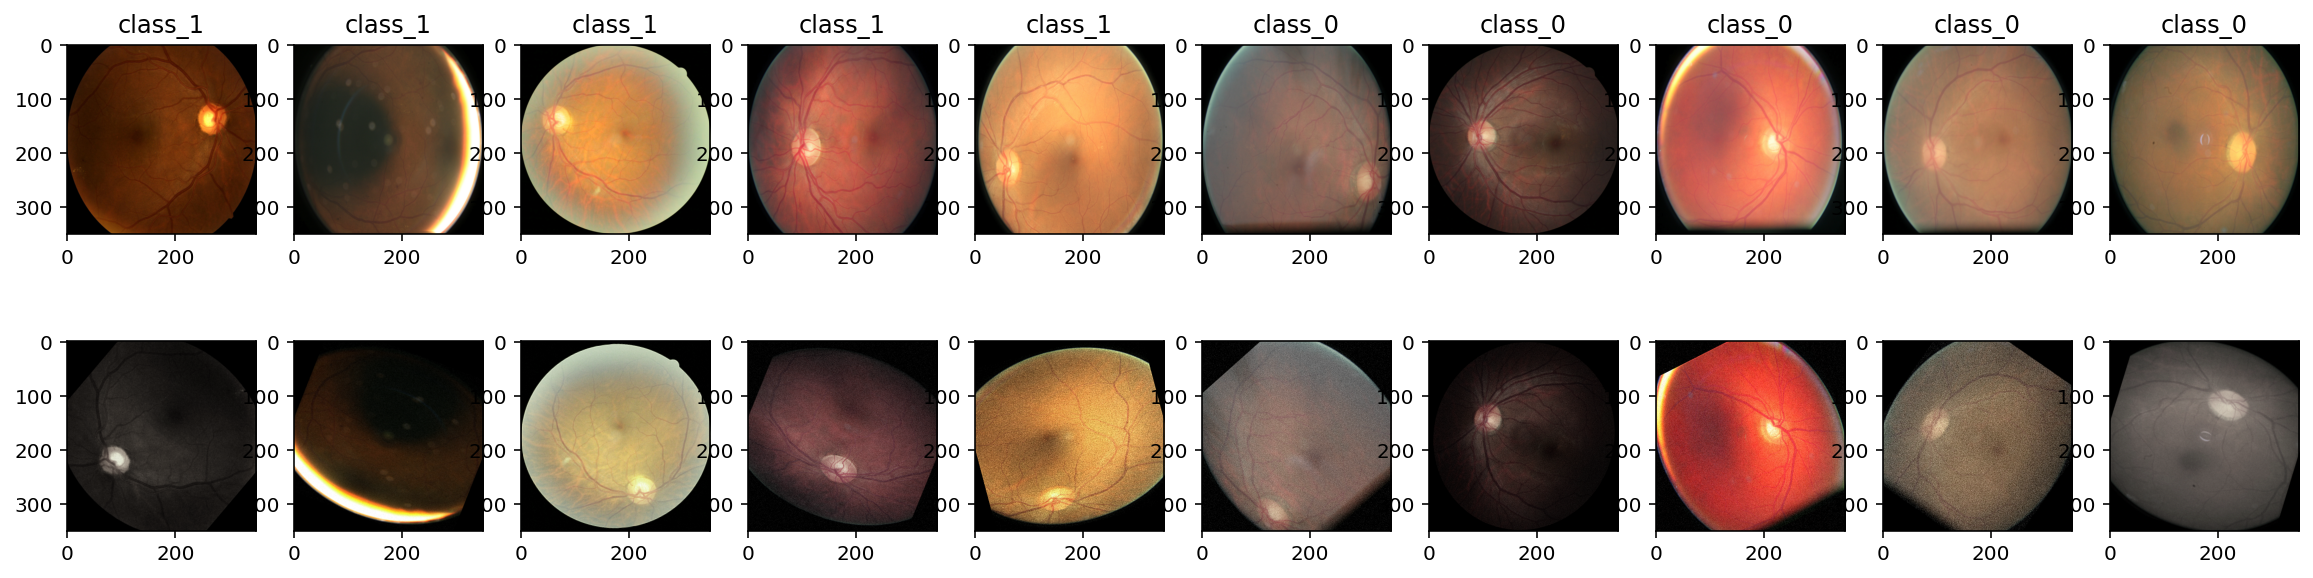

In [6]:
fig, ax = plt.subplots(2, 10, figsize=(20,5))
dl_train_plot = DataLoader(df_train, batch_size=10, sampler=train_sampler, num_workers=0)

for (im, im_aug, label) in dl_train_plot:
    break

for i in range(10):
    ax[0,i].imshow(tensor_to_image(im[i]))
    ax[0,i].set_title('class_' + str(label[i].item()))
    ax[1,i].imshow(tensor_to_image(im_aug[i]))

In [7]:
diag_net = basic_cnn(3, 2)
diag_net = model.MyDataParallel(diag_net)
diag_net = diag_net.to(device)
opt = torch.optim.SGD(diag_net.parameters(), lr=.01, momentum=0.9, weight_decay=5e-4)

def lr_lambda(epoch):
    if epoch < 6:
        return 1
    elif epoch >= 6 and epoch < 8:
        return 0.16666667
    elif epoch >= 8 and epoch < 9:
        return 0.0335
    else:
        return 0.01

scheduler_basic_cnn = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)
sup_cr = nn.CrossEntropyLoss()

In [ ]:
# Not Working

In [8]:
# train_loss_list = []
# for ep in range(10):
#     scheduler_basic_cnn.step(ep)
#     train_loss_for_current_epoch = train_basic_cnn(ep, diag_net, dl_train, dl_test, opt, sup_cr)
#     train_loss_list.extend(train_loss_for_current_epoch)

/data/Atin/anaconda3/envs/ssl_new/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/data/Atin/anaconda3/envs/ssl_new/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are 

Epoch is 0/10 | (0/576)|Loss:0.7123 | Avg. Loss: 0.7123 |


/data/Atin/anaconda3/envs/ssl_new/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.6938, Accuracy: 300/600 (50%)

AUC is 0.4933
Epoch is 0/10 | (4/576)|Loss:0.6936 | Avg. Loss: 0.6972 |
Epoch is 0/10 | (8/576)|Loss:0.6953 | Avg. Loss: 0.6945 |
Epoch is 0/10 | (12/576)|Loss:0.6919 | Avg. Loss: 0.6944 |
Epoch is 0/10 | (16/576)|Loss:0.6916 | Avg. Loss: 0.6940 |
Epoch is 0/10 | (20/576)|Loss:0.6970 | Avg. Loss: 0.6940 |
Epoch is 0/10 | (24/576)|Loss:0.6926 | Avg. Loss: 0.6940 |
Epoch is 0/10 | (28/576)|Loss:0.6931 | Avg. Loss: 0.6939 |
Epoch is 0/10 | (32/576)|Loss:0.6932 | Avg. Loss: 0.6938 |
Epoch is 0/10 | (36/576)|Loss:0.6944 | Avg. Loss: 0.6938 |
Epoch is 0/10 | (40/576)|Loss:0.6962 | Avg. Loss: 0.6938 |
Epoch is 0/10 | (44/576)|Loss:0.6922 | Avg. Loss: 0.6938 |
Epoch is 0/10 | (48/576)|Loss:0.6931 | Avg. Loss: 0.6938 |
Epoch is 0/10 | (52/576)|Loss:0.6946 | Avg. Loss: 0.6938 |
Epoch is 0/10 | (56/576)|Loss:0.6925 | Avg. Loss: 0.6937 |
Epoch is 0/10 | (60/576)|Loss:0.6929 | Avg. Loss: 0.6936 |
Epoch is 0/10 | (64/576)|Loss:0.6937 | Avg. L

Epoch is 0/10 | (540/576)|Loss:0.6924 | Avg. Loss: 0.6935 |
Epoch is 0/10 | (544/576)|Loss:0.6929 | Avg. Loss: 0.6935 |
Epoch is 0/10 | (548/576)|Loss:0.6932 | Avg. Loss: 0.6935 |
Epoch is 0/10 | (552/576)|Loss:0.6940 | Avg. Loss: 0.6935 |
Epoch is 0/10 | (556/576)|Loss:0.6945 | Avg. Loss: 0.6935 |
Epoch is 0/10 | (560/576)|Loss:0.6932 | Avg. Loss: 0.6935 |
Epoch is 0/10 | (564/576)|Loss:0.6901 | Avg. Loss: 0.6935 |
Epoch is 0/10 | (568/576)|Loss:0.6934 | Avg. Loss: 0.6935 |
Epoch is 0/10 | (572/576)|Loss:0.6899 | Avg. Loss: 0.6935 |
Epoch is 1/10 | (0/576)|Loss:0.7001 | Avg. Loss: 0.7001 |

Test set: Average loss: 0.6936, Accuracy: 300/600 (50%)

AUC is 0.5000
Epoch is 1/10 | (4/576)|Loss:0.6954 | Avg. Loss: 0.6957 |
Epoch is 1/10 | (8/576)|Loss:0.6941 | Avg. Loss: 0.6953 |
Epoch is 1/10 | (12/576)|Loss:0.6937 | Avg. Loss: 0.6946 |
Epoch is 1/10 | (16/576)|Loss:0.6932 | Avg. Loss: 0.6943 |
Epoch is 1/10 | (20/576)|Loss:0.6929 | Avg. Loss: 0.6940 |
Epoch is 1/10 | (24/576)|Loss:0.6945 

Epoch is 1/10 | (500/576)|Loss:0.7024 | Avg. Loss: 0.6933 |
Epoch is 1/10 | (504/576)|Loss:0.7012 | Avg. Loss: 0.6933 |
Epoch is 1/10 | (508/576)|Loss:0.6928 | Avg. Loss: 0.6933 |
Epoch is 1/10 | (512/576)|Loss:0.6933 | Avg. Loss: 0.6933 |
Epoch is 1/10 | (516/576)|Loss:0.6933 | Avg. Loss: 0.6933 |
Epoch is 1/10 | (520/576)|Loss:0.6919 | Avg. Loss: 0.6933 |
Epoch is 1/10 | (524/576)|Loss:0.6955 | Avg. Loss: 0.6933 |
Epoch is 1/10 | (528/576)|Loss:0.6963 | Avg. Loss: 0.6933 |
Epoch is 1/10 | (532/576)|Loss:0.6975 | Avg. Loss: 0.6933 |
Epoch is 1/10 | (536/576)|Loss:0.6898 | Avg. Loss: 0.6933 |
Epoch is 1/10 | (540/576)|Loss:0.6994 | Avg. Loss: 0.6933 |
Epoch is 1/10 | (544/576)|Loss:0.6962 | Avg. Loss: 0.6933 |
Epoch is 1/10 | (548/576)|Loss:0.6919 | Avg. Loss: 0.6933 |
Epoch is 1/10 | (552/576)|Loss:0.6930 | Avg. Loss: 0.6933 |
Epoch is 1/10 | (556/576)|Loss:0.6925 | Avg. Loss: 0.6933 |
Epoch is 1/10 | (560/576)|Loss:0.6932 | Avg. Loss: 0.6933 |
Epoch is 1/10 | (564/576)|Loss:0.6915 | 

KeyboardInterrupt: 

# Trying much smaller scaled down resnet 

In [8]:
activations = nn.ModuleDict([
                ['lrelu', nn.LeakyReLU()],
                ['relu', nn.ReLU()]
    ])
class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2) # dynamic add padding based on the kernel_size
        
conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels, self.out_channels =  in_channels, out_channels
        self.blocks = nn.Identity()
        self.shortcut = nn.Identity()   
    
    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        return x
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels
    
from collections import OrderedDict

class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):
        super().__init__(in_channels, out_channels)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(OrderedDict(
        {
            'conv' : nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
            'bn' : nn.BatchNorm2d(self.expanded_channels)
            
        })) if self.should_apply_shortcut else None
        
        
    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels
    
def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(OrderedDict({'conv': conv(in_channels, out_channels, *args, **kwargs), 
                          'bn': nn.BatchNorm2d(out_channels) }))

class ResNetBasicBlock(ResNetResidualBlock):
    expansion = 1
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation(),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )
        
class ResNetLayer(nn.Module):
    def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        # 'We perform downsampling directly by convolutional layers that have a stride of 2.'
        downsampling = 2 if in_channels != out_channels else 1
        
        self.blocks = nn.Sequential(
            block(in_channels , out_channels, *args, **kwargs, downsampling=downsampling),
            *[block(out_channels * block.expansion, 
                    out_channels, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x
    
class ResNetEncoder(nn.Module):
    """
    ResNet encoder composed by increasing different layers with increasing features.
    """
    def __init__(self, in_channels=3, blocks_sizes=[64, 128, 256, 512], deepths=[2,2,2,2], 
                 activation=nn.ReLU, block=ResNetBasicBlock, *args,**kwargs):
        super().__init__()
        
        self.blocks_sizes = blocks_sizes
        
        self.gate = nn.Sequential(
            nn.Conv2d(in_channels, self.blocks_sizes[0], kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.blocks_sizes[0]),
            activation(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.in_out_block_sizes = list(zip(blocks_sizes, blocks_sizes[1:]))
        self.blocks = nn.ModuleList([ 
            ResNetLayer(blocks_sizes[0], blocks_sizes[0], n=deepths[0], activation=activation, 
                        block=block,  *args, **kwargs),
            *[ResNetLayer(in_channels * block.expansion, 
                          out_channels, n=n, activation=activation, 
                          block=block, *args, **kwargs) 
              for (in_channels, out_channels), n in zip(self.in_out_block_sizes, deepths[1:])]       
        ])
        
        
    def forward(self, x):
        x = self.gate(x)
        for block in self.blocks:
            x = block(x)
        return x

class ResnetDecoder(nn.Module):
    """
    This class represents the tail of ResNet. It performs a global pooling and maps the output to the
    correct class by using a fully connected layer.
    """
    def __init__(self, in_features, n_classes):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d((1, 1))
        self.decoder = nn.Linear(in_features, n_classes)

    def forward(self, x):
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.decoder(x)
        return x
    
class ResNet(nn.Module):
    
    def __init__(self, in_channels, n_classes, *args, **kwargs):
        super().__init__()
        self.encoder = ResNetEncoder(in_channels, *args, **kwargs)
        self.decoder = ResnetDecoder(self.encoder.blocks[-1].blocks[-1].expanded_channels, n_classes)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    


In [9]:
def resnet_small(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBasicBlock, deepths=[1, 1, 1, 1], 
                  blocks_sizes=[32, 64, 128, 256])

In [10]:
from torchsummary import summary

resnet_model = resnet_small(3, 2)
summary(resnet_model.cuda(), (3, 350, 350))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 175, 175]           4,704
       BatchNorm2d-2         [-1, 32, 175, 175]              64
              ReLU-3         [-1, 32, 175, 175]               0
         MaxPool2d-4           [-1, 32, 88, 88]               0
        Conv2dAuto-5           [-1, 32, 88, 88]           9,216
       BatchNorm2d-6           [-1, 32, 88, 88]              64
              ReLU-7           [-1, 32, 88, 88]               0
        Conv2dAuto-8           [-1, 32, 88, 88]           9,216
       BatchNorm2d-9           [-1, 32, 88, 88]              64
 ResNetBasicBlock-10           [-1, 32, 88, 88]               0
      ResNetLayer-11           [-1, 32, 88, 88]               0
           Conv2d-12           [-1, 64, 44, 44]           2,048
      BatchNorm2d-13           [-1, 64, 44, 44]             128
       Conv2dAuto-14           [-1, 64,

In [11]:
diag_net = basic_cnn(3, 2)
summary(diag_net.cuda(), (3, 350, 350))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 348, 348]             896
       BatchNorm2d-2         [-1, 32, 348, 348]              64
              ReLU-3         [-1, 32, 348, 348]               0
           in_conv-4         [-1, 32, 348, 348]               0
            Conv2d-5         [-1, 32, 346, 346]           9,248
       BatchNorm2d-6         [-1, 32, 346, 346]              64
              ReLU-7         [-1, 32, 346, 346]               0
            Conv2d-8         [-1, 32, 344, 344]           9,248
         MaxPool2d-9         [-1, 32, 171, 171]               0
      BatchNorm2d-10         [-1, 32, 171, 171]              64
             ReLU-11         [-1, 32, 171, 171]               0
      double_conv-12         [-1, 32, 171, 171]               0
           Conv2d-13         [-1, 64, 169, 169]          18,496
      BatchNorm2d-14         [-1, 64, 1

In [12]:
diag_net = resnet_small(3, 2)
diag_net = model.MyDataParallel(diag_net)
diag_net = diag_net.to(device)
opt = torch.optim.SGD(diag_net.parameters(), lr=.01, momentum=0.9, weight_decay=5e-4)

def lr_lambda(epoch):
    if epoch < 6:
        return 1
    elif epoch >= 6 and epoch < 8:
        return 0.16666667
    elif epoch >= 8 and epoch < 9:
        return 0.0335
    else:
        return 0.01

scheduler_basic_cnn = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)
sup_cr = nn.CrossEntropyLoss()



In [ ]:
train_loss_list_resnet = []
for ep in range(10):
    scheduler_basic_cnn.step(ep)
    train_loss_for_current_epoch = train_basic_cnn(ep, diag_net, dl_train, dl_test, opt, sup_cr)
    train_loss_list_resnet.extend(train_loss_for_current_epoch)

/data/Atin/anaconda3/envs/ssl_new/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/data/Atin/anaconda3/envs/ssl_new/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are 

Epoch is 0/10 | (0/576)|Loss:0.6927 | Avg. Loss: 0.6927 |


/data/Atin/anaconda3/envs/ssl_new/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.6927, Accuracy: 300/600 (50%)

AUC is 0.4889
Epoch is 0/10 | (4/576)|Loss:0.6912 | Avg. Loss: 0.6926 |
Epoch is 0/10 | (8/576)|Loss:0.6962 | Avg. Loss: 0.6934 |
Epoch is 0/10 | (12/576)|Loss:0.7025 | Avg. Loss: 0.6944 |
Epoch is 0/10 | (16/576)|Loss:0.6846 | Avg. Loss: 0.6940 |
Epoch is 0/10 | (20/576)|Loss:0.6864 | Avg. Loss: 0.6936 |
Epoch is 0/10 | (24/576)|Loss:0.7086 | Avg. Loss: 0.6939 |
Epoch is 0/10 | (28/576)|Loss:0.6867 | Avg. Loss: 0.6932 |
Epoch is 0/10 | (32/576)|Loss:0.6949 | Avg. Loss: 0.6932 |
Epoch is 0/10 | (36/576)|Loss:0.6855 | Avg. Loss: 0.6930 |
Epoch is 0/10 | (40/576)|Loss:0.7012 | Avg. Loss: 0.6934 |
Epoch is 0/10 | (44/576)|Loss:0.6934 | Avg. Loss: 0.6934 |
Epoch is 0/10 | (48/576)|Loss:0.6918 | Avg. Loss: 0.6933 |
Epoch is 0/10 | (52/576)|Loss:0.6978 | Avg. Loss: 0.6934 |
Epoch is 0/10 | (56/576)|Loss:0.6984 | Avg. Loss: 0.6934 |
Epoch is 0/10 | (60/576)|Loss:0.6944 | Avg. Loss: 0.6935 |
Epoch is 0/10 | (64/576)|Loss:0.6897 | Avg. L